## AST516 - ECONOMETRICS
          FINAL ASSIGNMENT :: MD ARIFUZZAMAN (2018-2-82-004)

In [159]:
library(tidyverse)
library(lmtest)
library (ridge)
library(car)

# Importing Data

In [160]:
data = read_csv("data.csv")

Parsed with column specification:
cols(
  Y = col_integer(),
  X1 = col_integer(),
  X2 = col_integer(),
  X3 = col_integer(),
  X4 = col_integer()
)


## Descriptions of Data
Y - Number of weekly riders <br/> X1 - Price per Week(USD) <br/> X2 - Population of City <br/> X3 - Monthly income of Riders(USD) <br/> X4 - Average Parking Rates per Month(USD)

In [161]:
head(data)

Y,X1,X2,X3,X4
192000,15,1800000,5800,50
190400,15,1790000,6200,50
191200,15,1780000,6400,60
177600,25,1778000,6500,60
176800,25,1750000,6550,60
178400,25,1740000,6580,70


# Outlier Check - Boxplot

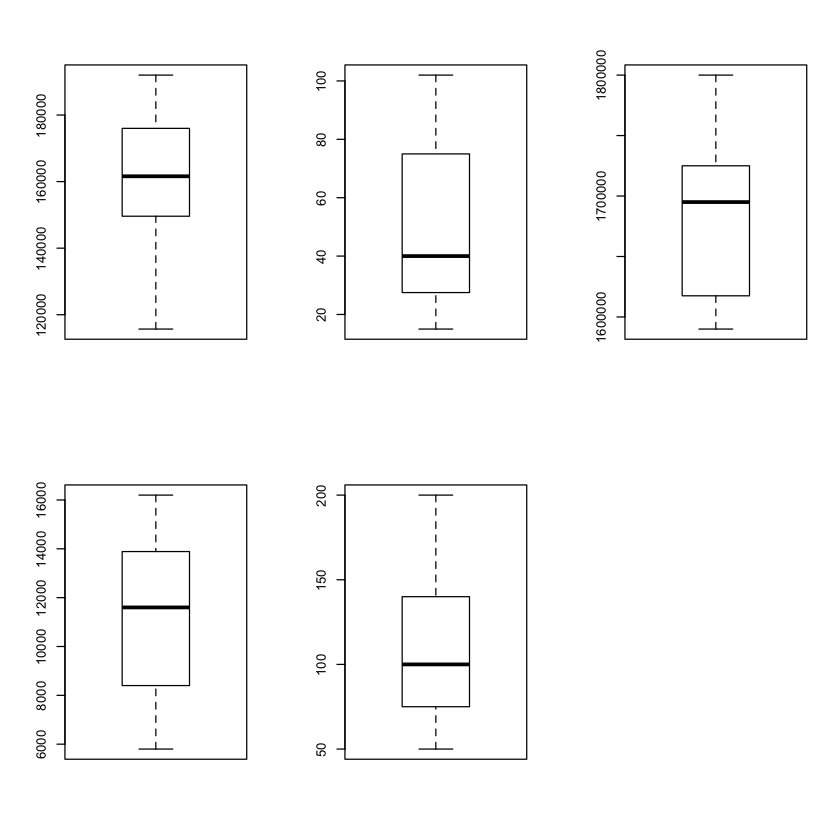

In [162]:
par(mfrow=c(2,3))
boxplot(data$Y)
boxplot(data$X1)
boxplot(data$X2)
boxplot(data$X3)
boxplot(data$X4)

# Prepare Training And Test Data

In [163]:
set.seed(100) # set seed to replicate results
trainingIndex = sample(1:nrow(data), 0.8*nrow(data)) # indices for 80% training data
trainingData = data[trainingIndex, ] # training data
testData = data[-trainingIndex, ] # test data

# Predict Using Linear Regression

In [164]:
lmMod = lm(Y ~ ., trainingData)  # the linear reg model
summary(lmMod)


Call:
lm(formula = Y ~ ., data = trainingData)

Residuals:
    Min      1Q  Median      3Q     Max 
-6221.9 -2631.1  -528.8  1331.8 11490.2 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.270e+05  1.751e+05   1.296    0.213    
X1          -7.479e+02  1.118e+02  -6.691 5.18e-06 ***
X2          -1.254e-02  9.424e-02  -0.133    0.896    
X3          -2.135e+00  1.507e+00  -1.417    0.176    
X4           1.320e+02  8.122e+01   1.625    0.124    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4743 on 16 degrees of freedom
Multiple R-squared:  0.9605,	Adjusted R-squared:  0.9507 
F-statistic: 97.39 on 4 and 16 DF,  p-value: 5.096e-11


In [165]:
predicted = predict (lmMod, testData)  # predict on test data
compare = cbind (actual=testData$Y, predicted)  # combine actual and predicted
print(compare)
accuracy = mean(apply(compare, 1, min)/apply(compare, 1, max))
print(paste("Accuracy: ", round(accuracy*100, 2)))

  actual predicted
1 192000  187399.4
2 159200  165215.0
3 148800  144641.4
4 150400  138329.1
5 123888  124317.0
6 151680  140230.8
[1] "Accuracy:  95.87"


## Multicolinerity

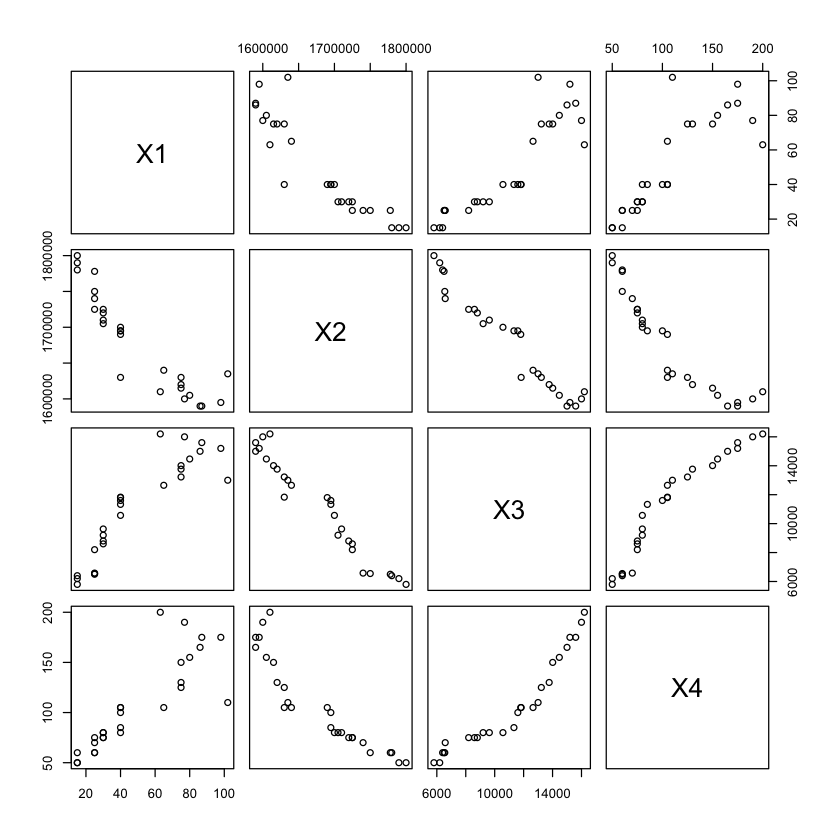

In [167]:
plot(data[-1])

In [168]:
round(cor(data), 2)

,Y,X1,X2,X3,X4
Y,1.00,-0.97,0.90,-0.87,-0.79
X1,-0.97,1.00,-0.91,0.90,0.85
X2,0.90,-0.91,1.00,-0.97,-0.92
X3,-0.87,0.90,-0.97,1.00,0.95
X4,-0.79,0.85,-0.92,0.95,1.00


    From the plot and correlation matrix, it is pretty clear that there are strong multicolinearity exists among the predictors

In [169]:
vif(lmMod)

X1        X2        X3        X4 
 7.990999 32.344371 22.229254 11.015248

    VIF test also confirms that strong multicolinerity exists among predicotors. we can confidently keep, one predictor and drop others to solve the multicolinearity problem.

## OLS without Multicolinearity

In [170]:
ols = lm(Y ~ X1, trainingData)

predicted = predict(ols, testData)  # predict on test data
compare = cbind(actual=testData$Y, predicted)  # combine actual and predicted
print(compare)
accuracy = mean(apply(compare, 1, min)/apply(compare, 1, max))
print(paste("Accuracy: ", round(accuracy*100, 2)))

  actual predicted
1 192000  186187.7
2 159200  166760.6
3 148800  147333.6
4 150400  139562.7
5 123888  121689.8
6 151680  138008.6
[1] "Accuracy:  95.58"


# Ridge Regression
        We can also solve multicolinearity using Ridge Regression.

In [176]:
linRidgeMod = linearRidge(Y ~ ., trainingData, nPCs=1)

predicted = predict(linRidgeMod, testData)  # predict on test data
compare = cbind(actual=testData$Y, predicted)  # combine actual and predicted
print(compare)
accuracy = mean(apply(compare, 1, min)/apply(compare, 1, max))
print(paste("Accuracy: ", round(accuracy*100, 2)))

  actual predicted
1 192000  188486.6
2 159200  161430.5
3 148800  145413.3
4 150400  138993.6
5 123888  125631.9
6 151680  139257.4
[1] "Accuracy:  96.23"


    We can see, Ridge Regression Improves Performance.

# Autocorrelation - Durbin-wattson Test

In [201]:
durbinWatsonTest(lmMod)

 lag Autocorrelation D-W Statistic p-value
   1      0.02139787      1.956137    0.97
 Alternative hypothesis: rho != 0

    Alternative hypothesis is true, thus Autocorrelation Exists

# Heteroscedasticity Test

## Graphical
    Residual Square vs. fit plot

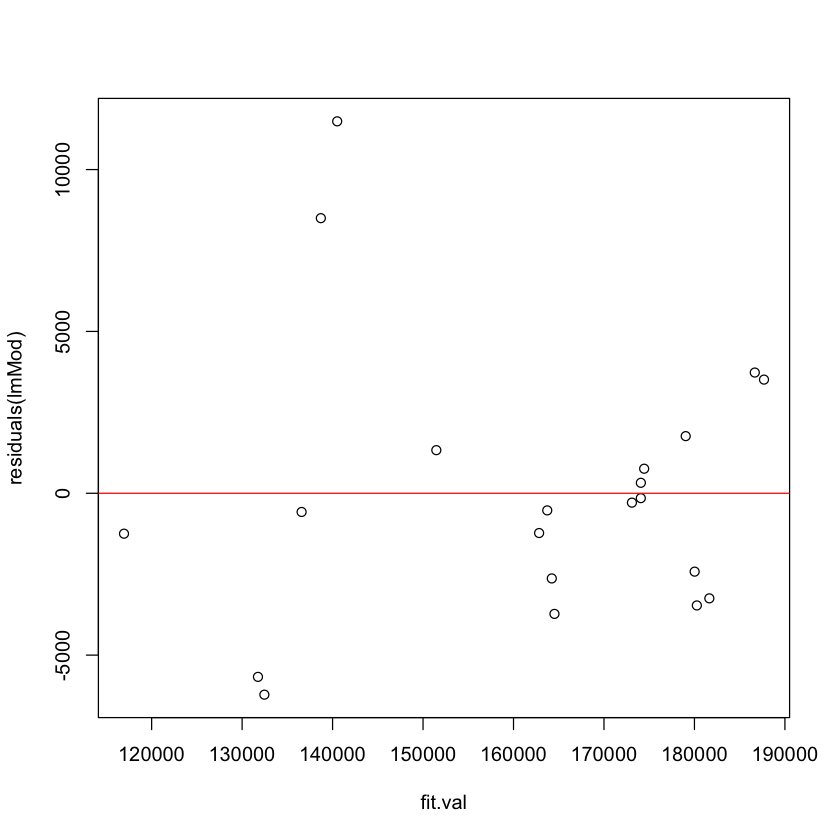

In [199]:
fit.val <- fitted.values(lmMod)
plot(fit.val, residuals(lmMod))
abline(0,0,col="red")

## Analytical
    Goldfeld-Quandt Test

In [202]:
gqtest(lmMod) 


	Goldfeld-Quandt test

data:  lmMod
GQ = 6.273, df1 = 6, df2 = 5, p-value = 0.03115
alternative hypothesis: variance increases from segment 1 to 2


    Breusch-Pagan test

In [203]:
bptest(lmMod)


	studentized Breusch-Pagan test

data:  lmMod
BP = 4.6888, df = 4, p-value = 0.3207


    Both Graphical and analytical test confirms Heteroscedasticity Exists

### Solving Heteroscedasticity by HCCM

In [204]:
library(sandwich)
coeftest(lmMod, vcov = vcovHC, type = "HC1")
# Can be used "HC1", "HC2", "HC3", "HC4" Estimators


t test of coefficients:

               Estimate  Std. Error  t value  Pr(>|t|)    
(Intercept)  2.2698e+05  1.3169e+05   1.7237   0.10403    
X1          -7.4788e+02  5.1545e+01 -14.5092 1.257e-10 ***
X2          -1.2542e-02  7.1068e-02  -0.1765   0.86213    
X3          -2.1355e+00  1.2036e+00  -1.7743   0.09505 .  
X4           1.3196e+02  5.3256e+01   2.4778   0.02476 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
